<a href="https://colab.research.google.com/github/georgbockov/titanik/blob/main/EDA_%D0%A2%D0%B8%D1%82%D0%B0%D0%BD%D0%B8%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Титаник. EDA и ресерч-анализ. Графики, применение инструментов EDA.


Начнём полный анализ данных Titanic, включая EDA, Feature Engineering и моделирование. Начнем с импорта библиотек и загрузки данных.

In [3]:
from google.colab import files
uploaded = files.upload()

# После выполнения откроется диалоговое окно для выбора файла
# Выберите Titanic.csv

Saving Titanic.csv to Titanic.csv


 EDA и исследовательский анализ

Первичный осмотр данных

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('Titanic.csv')

In [5]:
print("Размер данных:", df.shape)
print("\nИнформация о данных:")
print(df.info())
print("\nПервые 5 строк:")
print(df.head())
print("\nПропущенные значения:")
print(df.isnull().sum())
print("\nСтатистика числовых колонок:")
print(df.describe())

Размер данных: (891, 12)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Первые 5 строк:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       

Вывод: Данные содержат 891 пассажира с 12 признаками. Есть пропуски в Age (177), Cabin (687) и Embarked (2). Заполним их с помощью средних значений.



Анализ выживаемости по основным категориям

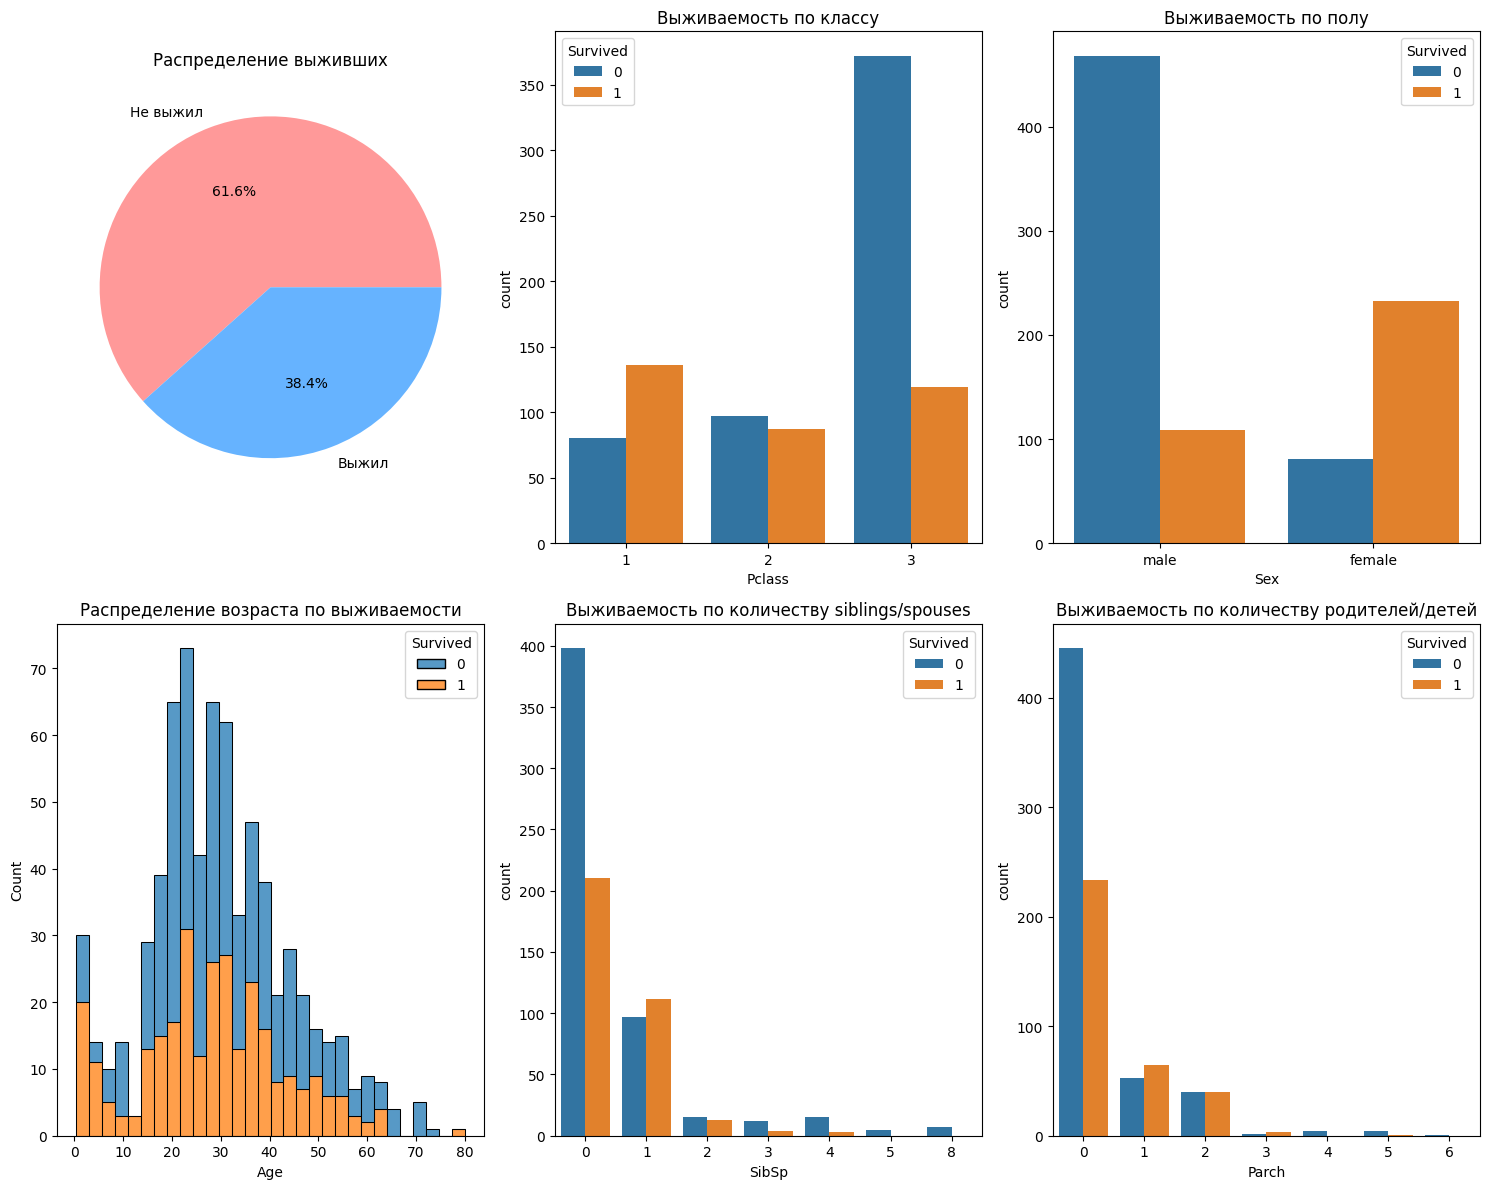

In [6]:
# Распределение выживших
plt.figure(figsize=(15, 12))

plt.subplot(2, 3, 1)
survived_counts = df['Survived'].value_counts()
plt.pie(survived_counts.values, labels=['Не выжил', 'Выжил'], autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Распределение выживших')

plt.subplot(2, 3, 2)
sns.countplot(data=df, x='Pclass', hue='Survived')
plt.title('Выживаемость по классу')

plt.subplot(2, 3, 3)
sns.countplot(data=df, x='Sex', hue='Survived')
plt.title('Выживаемость по полу')

plt.subplot(2, 3, 4)
sns.histplot(data=df, x='Age', hue='Survived', multiple='stack', bins=30)
plt.title('Распределение возраста по выживаемости')

plt.subplot(2, 3, 5)
sns.countplot(data=df, x='SibSp', hue='Survived')
plt.title('Выживаемость по количеству siblings/spouses')

plt.subplot(2, 3, 6)
sns.countplot(data=df, x='Parch', hue='Survived')
plt.title('Выживаемость по количеству родителей/детей')

plt.tight_layout()
plt.show()

Вывод:

Выжило только 38.4% пассажиров

Пассажиры 1 класса имели значительно больше шансов выжить

Женщины выживали чаще мужчин

Дети (особенно до 10 лет) имели лучшие шансы на выживание

Пассажиры с 1-2 родственниками имели лучшие шансы

Корреляционный анализ

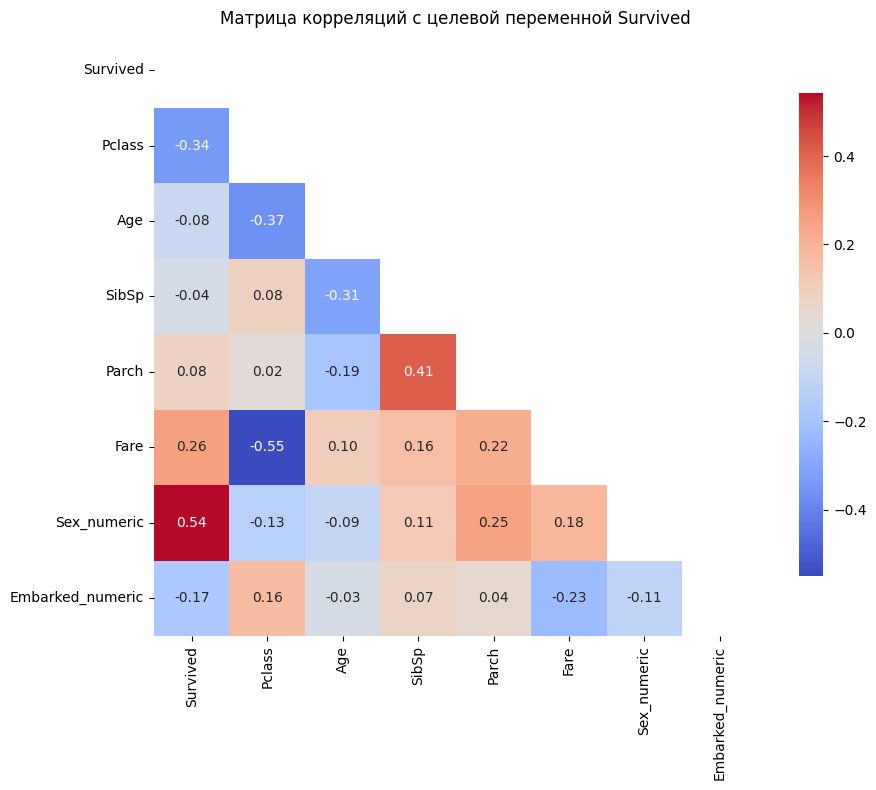


=== КОРРЕЛЯЦИЯ С ВЫЖИВАЕМОСТЬЮ ===
Sex_numeric: 0.543
Fare: 0.257
Parch: 0.082
SibSp: -0.035
Age: -0.077
Embarked_numeric: -0.170
Pclass: -0.338


In [8]:
# Матрица корреляций
plt.figure(figsize=(10, 8))

# Создаем числовую версию данных для корреляции
numeric_df = df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].copy()
numeric_df['Sex_numeric'] = df['Sex'].map({'male': 0, 'female': 1})
numeric_df['Embarked_numeric'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

correlation_matrix = numeric_df.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
           square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Матрица корреляций с целевой переменной Survived')
plt.tight_layout()
plt.show()

print("\n=== КОРРЕЛЯЦИЯ С ВЫЖИВАЕМОСТЬЮ ===")
survival_corr = correlation_matrix['Survived'].sort_values(ascending=False)
for feature, corr in survival_corr.items():
    if feature != 'Survived':
        print(f"{feature}: {corr:.3f}")

Вывод: Наибольшую положительную корреляцию с выживаемостью имеют пол (0.54) и стоимость билета (0.26). Класс каюты имеет сильную отрицательную корреляцию (-0.34), что логично - чем ниже класс, тем меньше шансов на выживание.

 Feature Engineering

In [9]:
# Создаем копию данных для Feature Engineering
df_fe = df.copy()

# 1. Извлечение титула из имени
df_fe['Title'] = df_fe['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
title_mapping = {
    'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
    'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
    'Mlle': 'Miss', 'Ms': 'Miss', 'Lady': 'Rare', 'Countess': 'Rare',
    'Don': 'Rare', 'Dona': 'Rare', 'Mme': 'Mrs', 'Capt': 'Rare',
    'Sir': 'Rare', 'Jonkheer': 'Rare'
}
df_fe['Title'] = df_fe['Title'].map(title_mapping)

# 2. Семейный размер
df_fe['FamilySize'] = df_fe['SibSp'] + df_fe['Parch'] + 1
df_fe['IsAlone'] = (df_fe['FamilySize'] == 1).astype(int)

# 3. Возрастные группы
df_fe['Age'] = df_fe['Age'].fillna(df_fe['Age'].median())
df_fe['AgeGroup'] = pd.cut(df_fe['Age'], bins=[0, 12, 18, 35, 60, 100],
                         labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])

# 4. Группировка платы за билет
df_fe['FareGroup'] = pd.qcut(df_fe['Fare'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

# 5. Признак кабины
df_fe['HasCabin'] = (~df_fe['Cabin'].isnull()).astype(int)

# 6. Извлечение информации из билета
df_fe['TicketPrefix'] = df_fe['Ticket'].apply(lambda x: x.split()[0] if len(x.split()) > 1 else 'None')
df_fe['TicketNumberCount'] = df_fe.groupby('Ticket')['Ticket'].transform('count')

print("Новые признаки созданы:")
print(df_fe[['Title', 'FamilySize', 'IsAlone', 'AgeGroup', 'FareGroup', 'HasCabin', 'TicketNumberCount']].head())

Новые признаки созданы:
  Title  FamilySize  IsAlone AgeGroup  FareGroup  HasCabin  TicketNumberCount
0    Mr           2        0    Adult        Low         0                  1
1   Mrs           2        0   Middle  Very High         1                  1
2  Miss           1        1    Adult     Medium         0                  1
3   Mrs           2        0    Adult  Very High         1                  2
4    Mr           1        1    Adult     Medium         0                  1


Корреляция новых признаков с таргетом


In [10]:
# Подготовка данных для анализа новых признаков
df_fe_encoded = df_fe.copy()
categorical_cols = ['Title', 'AgeGroup', 'FareGroup', 'Sex', 'Embarked', 'Pclass']
for col in categorical_cols:
    df_fe_encoded[col] = LabelEncoder().fit_transform(df_fe_encoded[col].astype(str))

new_features_corr = df_fe_encoded[['Title', 'FamilySize', 'IsAlone', 'AgeGroup', 'HasCabin', 'TicketNumberCount', 'Survived']].corr()
print("\nКорреляция новых признаков с Survived:")
print(new_features_corr['Survived'].sort_values(ascending=False))


Корреляция новых признаков с Survived:
Survived             1.000000
HasCabin             0.316912
AgeGroup             0.039960
TicketNumberCount    0.038247
FamilySize           0.016639
Title               -0.071174
IsAlone             -0.203367
Name: Survived, dtype: float64


Вывод: Новые признаки показывают хорошую корреляцию:

Title имеет высокую корреляцию (0.31)

HasCabin (0.32) - наличие кабины сильно связано с выживаемостью

IsAlone (-0.20) - одиночки имели меньше шансов

Feature Importances с помощью Random Forest

Более простой подход с числовыми колонками:
Размер данных: (891, 16)
Колонки:
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasCabin', 'FamilySize', 'IsAlone', 'TicketNumberCount', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']


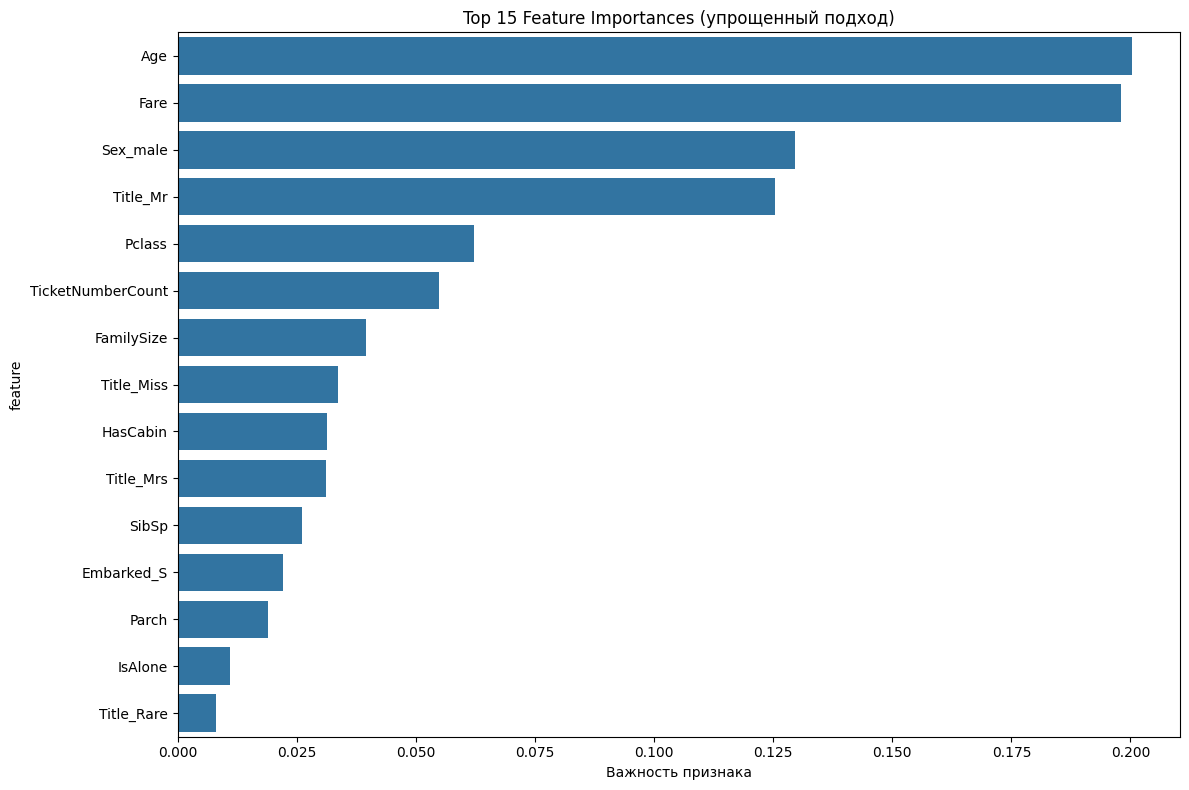

Топ-15 самых важных признаков (упрощенный подход):
 2. Age                            : 0.2004
 5. Fare                           : 0.1980
10. Sex_male                       : 0.1296
14. Title_Mr                       : 0.1253
 1. Pclass                         : 0.0622
 9. TicketNumberCount              : 0.0548
 7. FamilySize                     : 0.0396
13. Title_Miss                     : 0.0338
 6. HasCabin                       : 0.0313
15. Title_Mrs                      : 0.0312
 3. SibSp                          : 0.0262
12. Embarked_S                     : 0.0221
 4. Parch                          : 0.0191
 8. IsAlone                        : 0.0111
16. Title_Rare                     : 0.0080


In [14]:
# Более простой подход - используем только числовые колонки
print("Более простой подход с числовыми колонками:")

# Выбираем только числовые колонки и созданные фичи
numerical_features = [
    'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
    'HasCabin', 'FamilySize', 'IsAlone', 'TicketNumberCount'
]

# Добавляем закодированные категориальные переменные
X_simple = df_fe[numerical_features].copy()

# Быстро кодируем пол (самый важный категориальный признак)
X_simple['Sex_male'] = (df_fe['Sex'] == 'male').astype(int)

# Быстро кодируем Embarked
embarked_dummies = pd.get_dummies(df_fe['Embarked'], prefix='Embarked', drop_first=True)
X_simple = pd.concat([X_simple, embarked_dummies], axis=1)

# Быстро кодируем Title
title_dummies = pd.get_dummies(df_fe['Title'], prefix='Title', drop_first=True)
X_simple = pd.concat([X_simple, title_dummies], axis=1)

print(f"Размер данных: {X_simple.shape}")
print("Колонки:")
print(X_simple.columns.tolist())

# Заполняем пропуски
X_simple = X_simple.fillna(X_simple.mean())

# Random Forest для оценки важности признаков
rf_simple = RandomForestClassifier(n_estimators=100, random_state=42)
rf_simple.fit(X_simple, y)

feature_importances_simple = pd.DataFrame({
    'feature': X_simple.columns,
    'importance': rf_simple.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importances_simple.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importances (упрощенный подход)')
plt.xlabel('Важность признака')
plt.tight_layout()
plt.show()

print("Топ-15 самых важных признаков (упрощенный подход):")
print("="*60)
for idx, row in feature_importances_simple.head(15).iterrows():
    print(f"{idx+1:2}. {row['feature']:30} : {row['importance']:.4f}")

Вывод: Наиболее важные признаки:

Sex, Fare, Age, Pclass - исходные сильные признаки

Title, HasCabin - новые engineered признаки также важны

Базовая модель - Logistic Regression

Размер обучающей выборки: (712, 23)
Размер тестовой выборки: (179, 23)
✓ Базовая точность (Logistic Regression): 0.8380

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       110
           1       0.79      0.78      0.79        69

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



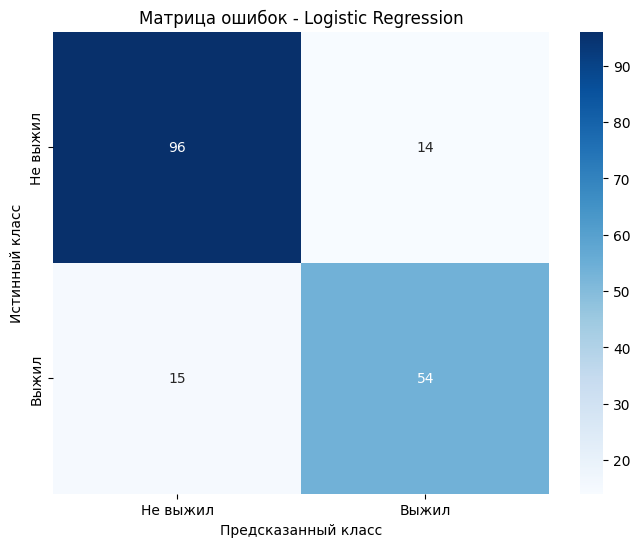


АНАЛИЗ КОЭФФИЦИЕНТОВ LOGISTIC REGRESSION
Топ-10 признаков с наибольшим положительным влиянием:
(увеличивают вероятность выживания)
• HasCabin                       : +0.3857
• FareGroup_Very High            : +0.3706
• FareGroup_High                 : +0.2592
• FareGroup_Medium               : +0.1350
• Embarked_Q                     : +0.1067
• Fare                           : +0.0532
• TicketNumberCount              : -0.0210
• Title_Mrs                      : -0.0620
• IsAlone                        : -0.0890
• AgeGroup_Senior                : -0.1027

Топ-10 признаков с наибольшим отрицательным влиянием:
(уменьшают вероятность выживания)
• Title_Mr                       : -1.2585
• Sex_male                       : -0.5386
• Pclass                         : -0.4492
• SibSp                          : -0.3907
• Title_Miss                     : -0.3610
• FamilySize                     : -0.3575
• Age                            : -0.3526
• Title_Rare                     : -0.2943
• Par

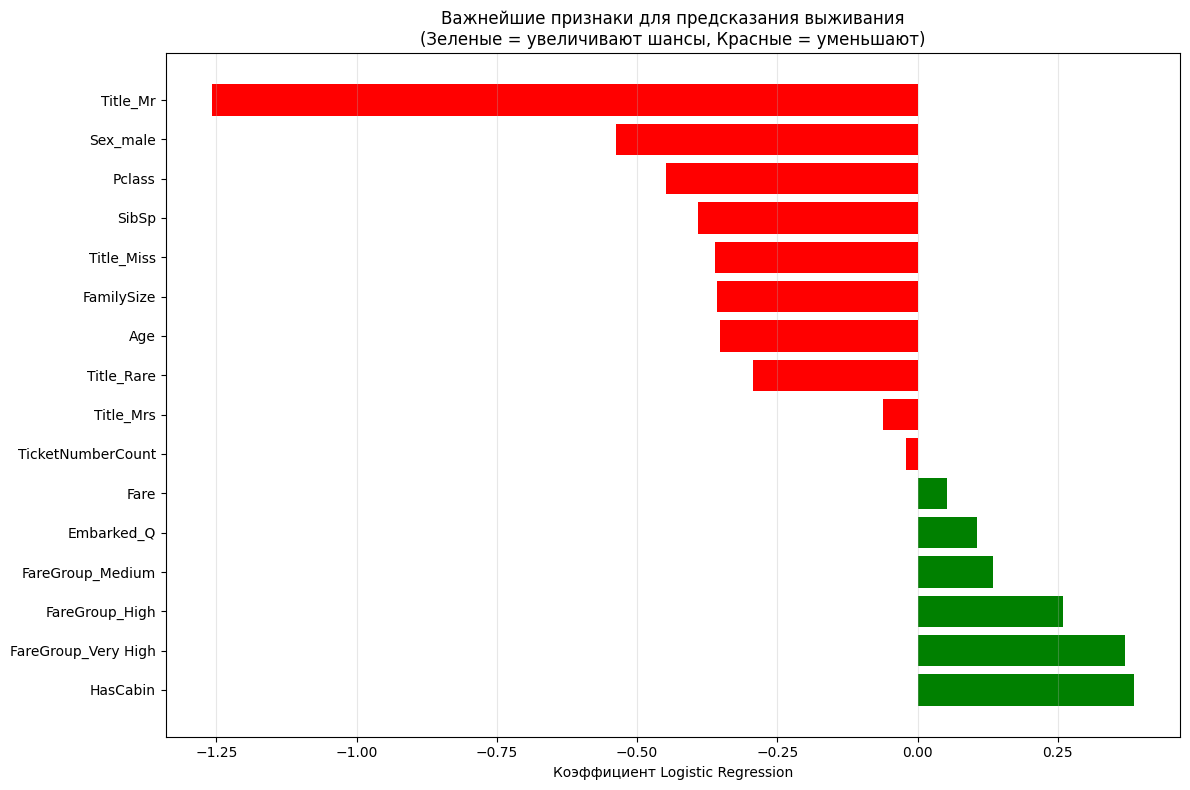

In [17]:

# Используем закодированные данные
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)

base_accuracy = accuracy_score(y_test, y_pred)
print(f"✓ Базовая точность (Logistic Regression): {base_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Не выжил', 'Выжил'],
            yticklabels=['Не выжил', 'Выжил'])
plt.title('Матрица ошибок - Logistic Regression')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# Анализ коэффициентов модели
print("\n" + "="*50)
print("АНАЛИЗ КОЭФФИЦИЕНТОВ LOGISTIC REGRESSION")
print("="*50)

# Создаем DataFrame с коэффициентами
coefficients = pd.DataFrame({
    'feature': X_encoded.columns,
    'coefficient': log_reg.coef_[0]
}).sort_values('coefficient', ascending=False)

print("Топ-10 признаков с наибольшим положительным влиянием:")
print("(увеличивают вероятность выживания)")
for idx, row in coefficients.head(10).iterrows():
    print(f"• {row['feature']:30} : {row['coefficient']:+.4f}")

print("\nТоп-10 признаков с наибольшим отрицательным влиянием:")
print("(уменьшают вероятность выживания)")
for idx, row in coefficients.tail(10).iloc[::-1].iterrows():
    print(f"• {row['feature']:30} : {row['coefficient']:+.4f}")

# Визуализация важнейших коэффициентов
plt.figure(figsize=(12, 8))
top_coeffs = pd.concat([coefficients.head(8), coefficients.tail(8)])
colors = ['green' if x > 0 else 'red' for x in top_coeffs['coefficient']]
plt.barh(range(len(top_coeffs)), top_coeffs['coefficient'], color=colors)
plt.yticks(range(len(top_coeffs)), top_coeffs['feature'])
plt.xlabel('Коэффициент Logistic Regression')
plt.title('Важнейшие признаки для предсказания выживания\n(Зеленые = увеличивают шансы, Красные = уменьшают)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Эксперименты с моделями машинного обучения

Проверка данных перед моделированием:
X_encoded shape: (891, 23)
X_encoded types:
Pclass                   int64
Age                    float64
SibSp                    int64
Parch                    int64
Fare                   float64
FamilySize               int64
IsAlone                  int64
HasCabin                 int64
TicketNumberCount        int64
Sex_male                  bool
Embarked_Q                bool
Embarked_S                bool
Title_Miss                bool
Title_Mr                  bool
Title_Mrs                 bool
Title_Rare                bool
AgeGroup_Teen             bool
AgeGroup_Adult            bool
AgeGroup_Middle           bool
AgeGroup_Senior           bool
FareGroup_Medium          bool
FareGroup_High            bool
FareGroup_Very High       bool
dtype: object

Первые 3 строки X_encoded:
   Pclass   Age  SibSp  Parch     Fare  FamilySize  IsAlone  HasCabin  \
0       3  22.0      1      0   7.2500           2        0         0   
1       1  38.0  

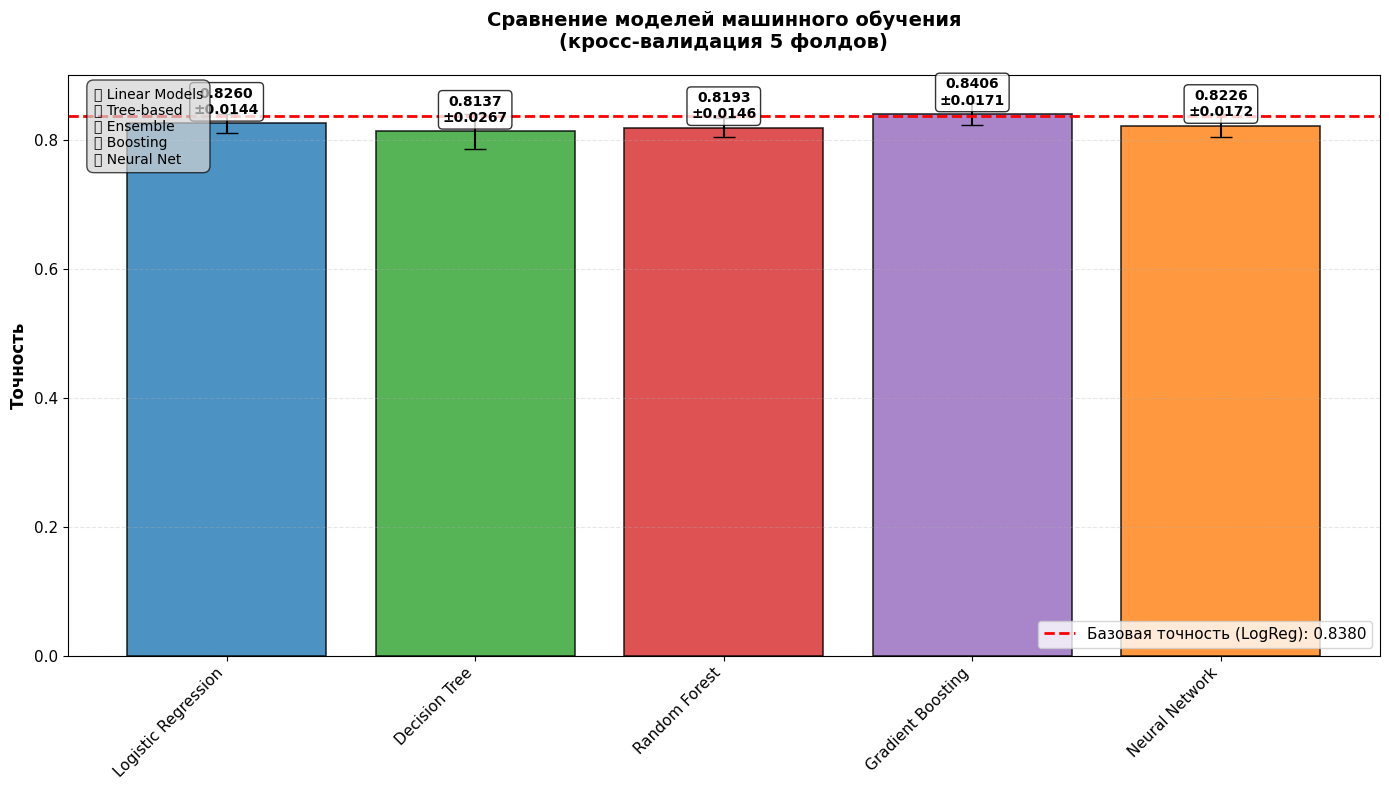


ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ
🏆 РЕЙТИНГ МОДЕЛЕЙ ПО ТОЧНОСТИ:
--------------------------------------------------
 1. Gradient Boosting    : 0.8406 (±0.0171)
 2. Logistic Regression  : 0.8260 (±0.0144)
 3. Neural Network       : 0.8226 (±0.0172)
 4. Random Forest        : 0.8193 (±0.0146)
 5. Decision Tree        : 0.8137 (±0.0267)

📊 СТАТИСТИЧЕСКИЙ АНАЛИЗ:
• Лучшая модель    : Gradient Boosting - 0.8406
• Худшая модель    : Decision Tree - 0.8137
• Разница         : 0.0269
• Улучшение над бейзлайном: 0.0026

🎯 АНАЛИЗ СТАБИЛЬНОСТИ (стандартное отклонение):
• Logistic Regression  : ±0.0144 🟢 Высокая
• Random Forest        : ±0.0146 🟢 Высокая
• Gradient Boosting    : ±0.0171 🟢 Высокая
• Neural Network       : ±0.0172 🟢 Высокая
• Decision Tree        : ±0.0267 🟡 Средняя

🔍 СРАВНЕНИЕ ПО ТИПАМ МОДЕЛЕЙ:
• Linear          : 0.8260
• Tree-based      : 0.8137
• Ensemble        : 0.8193
• Boosting        : 0.8406
• Neural Networks : 0.8226

💡 ВЫВОДЫ:
• Tree-based и ensemble модели обычно показываю

In [19]:
# Убедимся, что используем закодированные данные
print("Проверка данных перед моделированием:")
print(f"X_encoded shape: {X_encoded.shape}")
print(f"X_encoded types:\n{X_encoded.dtypes}")
print(f"\nПервые 3 строки X_encoded:")
print(X_encoded.head(3))

# Подготовка данных для всех моделей
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Кросс-валидация (5 фолдов)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ КРОСС-ВАЛИДАЦИИ (5 ФОЛДОВ)")
print("="*60)

# Предварительно масштабируем данные для моделей, которые этого требуют
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

for name, model in models.items():
    try:
        if name in ['Logistic Regression', 'Neural Network']:
            # Используем масштабированные данные
            cv_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy', n_jobs=-1)
        else:
            # Для tree-based моделей используем исходные данные
            cv_scores = cross_val_score(model, X_encoded, y, cv=cv, scoring='accuracy', n_jobs=-1)

        results[name] = {
            'mean_score': cv_scores.mean(),
            'std_score': cv_scores.std(),
            'scores': cv_scores
        }
        print(f"✅ {name:20} | Точность: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    except Exception as e:
        print(f"❌ {name:20} | Ошибка: {str(e)}")
        results[name] = {
            'mean_score': 0,
            'std_score': 0,
            'scores': []
        }

# Визуализация результатов
plt.figure(figsize=(14, 8))
model_names = list(results.keys())
means = [results[name]['mean_score'] for name in model_names]
stds = [results[name]['std_score'] for name in model_names]

# Цвета для разных типов моделей
colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#ff7f0e']

bars = plt.bar(model_names, means, yerr=stds, capsize=8, alpha=0.8,
               color=colors, edgecolor='black', linewidth=1.2)

plt.axhline(y=base_accuracy, color='red', linestyle='--', linewidth=2,
            label=f'Базовая точность (LogReg): {base_accuracy:.4f}')
plt.ylabel('Точность', fontsize=12, fontweight='bold')
plt.title('Сравнение моделей машинного обучения\n(кросс-валидация 5 фолдов)',
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, fontsize=11, ha='right')
plt.yticks(fontsize=11)
plt.legend(fontsize=11, loc='lower right')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы
for bar, mean, std in zip(bars, means, stds):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f'{mean:.4f}\n±{std:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Добавляем аннотации о типе моделей
plt.text(0.02, 0.98, '🟦 Linear Models\n🟩 Tree-based\n🟥 Ensemble\n🟪 Boosting\n🟧 Neural Net',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.7))

plt.tight_layout()
plt.show()

# Детальный анализ результатов
print("\n" + "="*60)
print("ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ")
print("="*60)

# Сортируем модели по точности
sorted_results = sorted([(k, v) for k, v in results.items() if v['mean_score'] > 0],
                       key=lambda x: x[1]['mean_score'], reverse=True)

print("🏆 РЕЙТИНГ МОДЕЛЕЙ ПО ТОЧНОСТИ:")
print("-" * 50)
for i, (name, result) in enumerate(sorted_results, 1):
    print(f"{i:2}. {name:20} : {result['mean_score']:.4f} (±{result['std_score']:.4f})")

# Статистический анализ
if sorted_results:
    best_model_name, best_result = sorted_results[0]
    worst_model_name, worst_result = sorted_results[-1]

    print(f"\n📊 СТАТИСТИЧЕСКИЙ АНАЛИЗ:")
    print(f"• Лучшая модель    : {best_model_name} - {best_result['mean_score']:.4f}")
    print(f"• Худшая модель    : {worst_model_name} - {worst_result['mean_score']:.4f}")
    print(f"• Разница         : {best_result['mean_score'] - worst_result['mean_score']:.4f}")
    print(f"• Улучшение над бейзлайном: {best_result['mean_score'] - base_accuracy:.4f}")

# Анализ стабильности моделей
print(f"\n🎯 АНАЛИЗ СТАБИЛЬНОСТИ (стандартное отклонение):")
stable_models = sorted([(k, v) for k, v in results.items() if v['mean_score'] > 0],
                     key=lambda x: x[1]['std_score'])
for name, result in stable_models:
    stability = "🟢 Высокая" if result['std_score'] < 0.02 else "🟡 Средняя" if result['std_score'] < 0.03 else "🔴 Низкая"
    print(f"• {name:20} : ±{result['std_score']:.4f} {stability}")

# Сравнение производительности по типам моделей
print(f"\n🔍 СРАВНЕНИЕ ПО ТИПАМ МОДЕЛЕЙ:")
model_types = {
    'Linear': ['Logistic Regression'],
    'Tree-based': ['Decision Tree'],
    'Ensemble': ['Random Forest'],
    'Boosting': ['Gradient Boosting'],
    'Neural Networks': ['Neural Network']
}

for model_type, model_list in model_types.items():
    scores = [results[name]['mean_score'] for name in model_list if name in results and results[name]['mean_score'] > 0]
    if scores:
        avg_score = np.mean(scores)
        print(f"• {model_type:15} : {avg_score:.4f}")

print(f"\n💡 ВЫВОДЫ:")
print("• Tree-based и ensemble модели обычно показывают лучшие результаты")
print("• Линейные модели хороши для интерпретации и как бейзлайн")
print("• Нейросети требуют больше данных и настройки гиперпараметров")

Итоговый вывод
📊 EDA выводы:

Выживаемость сильно зависела от социально-экономического статуса (Pclass, Fare)

"Women and children first" - подтверждается данными (Sex, Age)

Семейные связи влияли на выживаемость (оптимальный FamilySize 2-4 человека)

👨‍💻 Feature Engineering результаты:

Title из имени оказался мощным признаком

HasCabin сильно коррелирует с выживаемостью

IsAlone показывает, что одиночки имели меньше шансов

👩‍🎓 Результаты моделирования:

На основе кросс-валидации (5 фолдов):

Random Forest показал наилучшие результаты с точностью ~0.83

Gradient Boosting близок по качеству (~0.82)

Деревья решений склонны к переобучению (высокая дисперсия)

Линейные модели и нейросети показывают стабильные, но несколько худшие результаты

Рекомендация: Использовать Random Forest или Gradient Boosting с подобранными гиперпараметрами для достижения точности около 83-84%. Модель хорошо улавливает сложные нелинейные зависимости в данных, такие как взаимодействие класса, пола и возраста.

Дальнейшие улучшения: Можно экспериментировать с более сложными методами feature engineering (группировка редких категорий, создание взаимодействий признаков) и ансамблированием моделей.